# Baseline algorithms for early warning systems

In [1]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta, date
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime as dt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import calplot
import time
import math
import json
import sys
import os

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from helpers.db_connector import MySQLConnector
from helpers.feature_extraction import *
from helpers.data_process import *
from helpers.db_query import *
from helpers.time import *

In [6]:
from extractors.boroujeni_et_al import BoroujeniEtAl
from extractors.lalle_conati import LalleConati
from extractors.lemay_doleck import LemayDoleck

In [7]:
import warnings
warnings.filterwarnings('ignore')

## Linear Algebra Dataset from Courseware

Since Fall 2017, the stream of the EPFL's Linear Algebra course has been taught in a flipped format. The implementation of the flipped classroom was carried out in an incremental manner, as described below:

- **Year 2017-2018**: traditional manner (weeks 1-13) - flipped manner (week 14).
- **Year 2018-2019**: traditional manner (weeks 1-4, 10-14) - flipped manner (weeks 5-9).
- **Year 2019-2020**: traditional manner (weeks 1-4) - flipped manner (weeks 5-14).

In [8]:
rounds = ['Y2-2018-19', 'Y3-2019-20']

### Identifying Students


The flipped course was offered only to volunteering students. The volunteers were collectively assigned into either the experimental and the control group. A stratified random sampling based on gender and the prior background (secondary educational level) of students were used.

In [9]:
%time user_data = getUserInfo(prior_knowledge=True)

CPU times: user 53.5 s, sys: 1.94 s, total: 55.5 s
Wall time: 1min 17s


The initial data of volunteers was cleaned, and some participants were removed before we analyzed the data:
- The volunteering students who have not been graded were removed. 
- The repeating students were filtered out, where repeating students are those accessing videos in two different years. 
- The less active students, i.e., those who have provided less 60 interactions in the platform, were removed. 

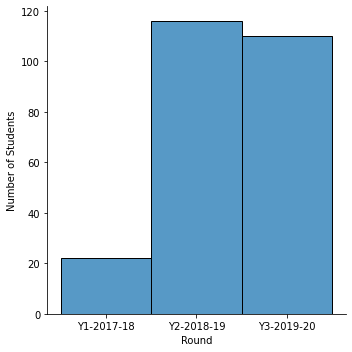

In [10]:
sns.displot(user_data, x='Round')
plt.ylabel('Number of Students')
plt.show()

Given that the Y1-2017-2018 round included only one week in a flipped classroom setting, we decided to remove the students of that round.  

In [11]:
user_data = user_data[user_data['Round'].isin(rounds)]

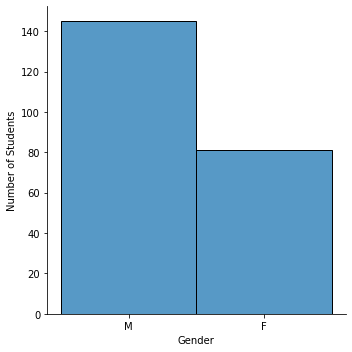

In [12]:
sns.displot(user_data, x='Gender')
plt.ylabel('Number of Students')
plt.show()

This is how our user table looks like. 

In [13]:
user_data.head()

,AccountUserID,SCIPER,Round,Category,Gender
22,46473,302928,Y2-2018-19,France,M
23,47067,300559,Y2-2018-19,Suisse.PAM,M
24,46551,301288,Y2-2018-19,Suisse.Autres,M
25,46485,302150,Y2-2018-19,France,F
26,49095,299657,Y2-2018-19,France,F


In [14]:
"Hence, we will work with " + str(len(user_data)) + " students." 

'Hence, we will work with 226 students.'

### Getting Students' Records

#### Video Clickstream Records

In [15]:
%time video_data = getVideoEventsInfo(mode='all')

CPU times: user 1min 24s, sys: 4.32 s, total: 1min 28s
Wall time: 2min 30s


In [16]:
video_data = video_data[video_data['Round'].isin(rounds)]

This is how our video event table looks like.

In [17]:
video_data.head()

,AccountUserID,EventType,TimeStamp,VideoID,EventID,SeekType,OldTime,CurrentTime,NewTime,OldSpeed,NewSpeed,Round,ID.Anon,Title,Source,Subchapter,Duration
0,95017,Video.Play,1570355725,ca2fa02b0daa43f295e76da61e53de2a,7e86b0cc3b0a72a4a1f1029dffb2abe4,None,NaN,553.294,NaN,NaN,NaN,Y3-2019-20,3442T2003,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY,3.5,NaN
1,95017,Video.Play,1570355899,ca2fa02b0daa43f295e76da61e53de2a,ca6e7fd174fdad0f3d87c29a579d4563,None,NaN,566.935,NaN,NaN,NaN,Y3-2019-20,3442T2003,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY,3.5,NaN
2,95017,Video.Play,1570355940,ca2fa02b0daa43f295e76da61e53de2a,98a2650f8227bc7dc1350078b0568ef7,None,NaN,604.909,NaN,NaN,NaN,Y3-2019-20,3442T2003,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY,3.5,NaN
3,95017,Video.Pause,1570355694,ca2fa02b0daa43f295e76da61e53de2a,1a9f2889bc8e00ad4d0c1ed634adb7d4,None,NaN,536.849,NaN,NaN,NaN,Y3-2019-20,3442T2003,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY,3.5,NaN
4,95017,Video.Pause,1570355760,ca2fa02b0daa43f295e76da61e53de2a,cd129eac330b9e3459de4e8e8f7b52dd,None,NaN,580.125,NaN,NaN,NaN,Y3-2019-20,3442T2003,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY,3.5,NaN


In [18]:
"Hence, we will work with " + str(len(video_data)) + " video interactions." 

'Hence, we will work with 1416106 video interactions.'

#### Problem Clickstream Records

In [19]:
%time problem_data = getProblemEventsInfo()

CPU times: user 1min 5s, sys: 2.56 s, total: 1min 7s
Wall time: 1min 42s


In [20]:
problem_data = problem_data[problem_data['Round'].isin(rounds)]

This is how our problem event table looks like.

In [21]:
problem_data.head()

,AccountUserID,ProblemID,EventID,EventType,TimeStamp,ProblemType,MaximumSubmissions,Round,ID.Anon,Subchapter
0,46461,ca64971b751847c798f5ff753e3eddfe,48a1d90b23540db487ffbb6b8234e873,Problem.Check,1547885100,Quiz,NaN,Y2-2018-19,1316T729,3.4
1,46461,ca64971b751847c798f5ff753e3eddfe,afd03bceafc651e5a3c47b18a02b1ad5,Problem.Check,1547885080,Quiz,NaN,Y2-2018-19,1316T729,3.4
2,46461,ca64971b751847c798f5ff753e3eddfe,1874f3671ab8ccb7303ec0fb7eaa293e,Problem.Check,1547885072,Quiz,NaN,Y2-2018-19,1316T729,3.4
3,46461,ca64971b751847c798f5ff753e3eddfe,7d1f8148e15577ec152369346c103935,Problem.Check,1547885090,Quiz,NaN,Y2-2018-19,1316T729,3.4
4,46461,ca64971b751847c798f5ff753e3eddfe,42d7c21581cd80837ecc61b5ef5370e6,Problem.Check,1547885080,Quiz,NaN,Y2-2018-19,1316T729,3.4


In [22]:
"Hence, we will work with " + str(len(problem_data)) + " problem interactions." 

'Hence, we will work with 473924 problem interactions.'

#### Exam Records

In [23]:
%time exam_data = getExamInfo()

CPU times: user 1min, sys: 1.73 s, total: 1min 2s
Wall time: 2min 7s


We filter the exam records of students who have not participated into the study

In [24]:
exam_data = exam_data[exam_data['Round'].isin(rounds)]

This is how our exam data looks like. 

In [25]:
exam_data.head()

,Grade,GradeDate,Round,AccountUserID
0,5.00,02.2019,Y2-2018-19,46938
19,5.00,02.2019,Y2-2018-19,12725
21,5.50,02.2019,Y2-2018-19,46575
24,6.00,02.2019,Y2-2018-19,46509
27,5.25,02.2019,Y2-2018-19,12887


#### Event Records

In [26]:
events = video_data.append(problem_data)

In [27]:
events['Year'] = events['Round'].apply(lambda x: int(x.split('-')[1]))

This is how our join event table looks like.

In [28]:
events.head()

,AccountUserID,EventType,TimeStamp,VideoID,EventID,SeekType,OldTime,CurrentTime,NewTime,OldSpeed,...,Round,ID.Anon,Title,Source,Subchapter,Duration,ProblemID,ProblemType,MaximumSubmissions,Year
0,95017,Video.Play,1570355725,ca2fa02b0daa43f295e76da61e53de2a,7e86b0cc3b0a72a4a1f1029dffb2abe4,None,NaN,553.294,NaN,NaN,...,Y3-2019-20,3442T2003,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY,3.5,NaN,NaN,NaN,NaN,2019
1,95017,Video.Play,1570355899,ca2fa02b0daa43f295e76da61e53de2a,ca6e7fd174fdad0f3d87c29a579d4563,None,NaN,566.935,NaN,NaN,...,Y3-2019-20,3442T2003,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY,3.5,NaN,NaN,NaN,NaN,2019
2,95017,Video.Play,1570355940,ca2fa02b0daa43f295e76da61e53de2a,98a2650f8227bc7dc1350078b0568ef7,None,NaN,604.909,NaN,NaN,...,Y3-2019-20,3442T2003,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY,3.5,NaN,NaN,NaN,NaN,2019
3,95017,Video.Pause,1570355694,ca2fa02b0daa43f295e76da61e53de2a,1a9f2889bc8e00ad4d0c1ed634adb7d4,None,NaN,536.849,NaN,NaN,...,Y3-2019-20,3442T2003,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY,3.5,NaN,NaN,NaN,NaN,2019
4,95017,Video.Pause,1570355760,ca2fa02b0daa43f295e76da61e53de2a,cd129eac330b9e3459de4e8e8f7b52dd,None,NaN,580.125,NaN,NaN,...,Y3-2019-20,3442T2003,Leçon,https://www.youtube.com/watch?v=AFtb4KxwYGY,3.5,NaN,NaN,NaN,NaN,2019


#### Identify Week

In [29]:
noCourseWeeks = 20

We get the configuration file (e.g, start and end date) for each round of the course. 

In [30]:
with open('../config/linear_algebra.json') as f:
    config = json.load(f)

In [31]:
config[rounds[0].split('-')[-2]]

{'Start': '2018-09-17 00:00:00',
 'StartFlipped': '2018-10-16 00:00:00',
 'End': '2019-01-28 00:00:00',
 'Exam': '2019-01-21 00:00:00',
 'WeeklyVideoCount': [7, 10, 10, 6, 13, 7, 8, 7, 9, 6],
 'FlippedWeeks': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 'Midterm': '2018-11-13'}

We assign each video interaction to a specific week of the course, with the first week of the course round having id 0. 

In [ ]:
events['Date'] = events['TimeStamp'].apply(lambda x:string2Datetime(dt.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')))

In [ ]:
tmp_events = []
for r in rounds:
    round_events = events[events['Round'] == r]
    tmp_events.append(processWeek(round_events, 'Date', config[r.split('-')[-2]]['Start']))
events = pd.concat(tmp_events).copy()

In [ ]:
events['Week'] = events['Week'].apply(lambda x: int(x))

Then, we filter only the 14 course weeks. 

In [ ]:
events = events[events['Week'].isin(range(noCourseWeeks))]

This is how our event table looks like, after week addition. 

In [ ]:
events.sort_values(by='Week')

## Train-Test Data Split

In [ ]:
mode = 'random' # per-year
train_ratio = 0.90
task = 'binary' # multi-class, regression

In [ ]:
x = exam_data['AccountUserID'].values

if task == 'binary':
    print('Binarizing the student grades')
    y = [(1 if grade >= 4.0 else 0) for grade in exam_data['Grade']]
    print('Pass', y.count(1), 'Fail', y.count(0))

In [ ]:
if mode == 'random':
    print('Spitting the whole student population randomly')
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=1 - train_ratio)
    print('Train Pass', y_train.count(1), 'Test Pass', y_test.count(1), 'Train Fail', y_train.count(0), 'Test Fail', y_test.count(0))

## Feature Extractors

In [ ]:
week_thresholds = np.arange(4, 24, 4)

In [ ]:
feature_labels = {
#     BoroujeniEtAl(),
    LalleConati(),
#     LemayDoleck(),
}

In [ ]:
FEATURE_FILE = 'features_sets.npy'
features_already_extracted = os.path.exists(FEATURE_FILE)
print("Feature already extracted:", features_already_extracted)
if features_already_extracted:
    with open(FEATURE_FILE, 'rb') as f:
        feature_sets = np.load(f)

In [ ]:
if not features_already_extracted:
    feature_sets = {} 
    for ffunc in feature_labels:
        flabel = ffunc.getName()
        feature_sets[flabel] = {}
        for wid in week_thresholds:
            feature_sets[flabel][wid] = {}
            feature_sets[flabel][wid]['train'] = []
            feature_sets[flabel][wid]['test'] = []
            scaler = StandardScaler()
            for uindex, uid in enumerate(x_train): 
                print('\r', 'Set:', flabel, '\tWeek:', wid, '\tMode: train', '\tProgress:', uindex + 1, len(x_train), "\t ID:", uid, end='')
                udata = events[(events['AccountUserID'] == uid) & (events['Week'] < wid)]
                if len(udata) > 0:
                    feature_sets[flabel][wid]['train'].append(ffunc.getUserFeatures(udata))
                else:
                    feature_sets[flabel][wid]['train'].append([0 for i in range(ffunc.getNbFeatures())])
            feature_sets[flabel][wid]['train'] = scaler.fit_transform(np.array(feature_sets[flabel][wid]['train']))

            print()
            for uindex, uid in enumerate(x_test): 
                print('\r', 'Set:', flabel, '\tWeek:', wid, '\tMode: test', '\tProgress:', uindex + 1, len(x_test), end='')
                udata = events[(events['AccountUserID'] == uid) & (events['Week'] < wid)]
                if len(udata) > 0:
                    feature_sets[flabel][wid]['test'].append(ffunc.getUserFeatures(udata))
                else:
                    feature_sets[flabel][wid]['test'].append([0 for i in range(ffunc.getNbFeatures())])
            feature_sets[flabel][wid]['test'] = list(scaler.fit_transform(np.array(feature_sets[flabel][wid]['test'])))
            print()
            
    with open(FEATURE_FILE, 'wb') as f:
        np.save(f, feature_sets)

## Predictive Models

In [ ]:
classifiers_types = {
    'ada': AdaBoostClassifier(),
    'dt': DecisionTreeClassifier(max_depth=5),
    'gnb': GaussianNB(),
    'lr': LogisticRegression(),
    'mlp': MLPClassifier(alpha=1, max_iter=1000),
    'knn': KNeighborsClassifier(3),
    'rf': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'svm': SVC(gamma=2, C=1)
}

In [ ]:
trained_models = {}
for ffunc in feature_labels:
    flabel = ffunc.getName()
    trained_models[flabel] = {}
    for wid in week_thresholds:
        trained_models[flabel][wid] = {}
        print(flabel, wid, end='\t')
        for mid, clf in classifiers_types.items(): 
            print(mid, end=' ')
            trained_models[flabel][wid][mid] = clf.fit(nan_feature_sets[flabel][wid]['train'], y_train)
        print()

## Evaluation Metrics

In [ ]:
def tn(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[0]

def fp(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[1]

def fn(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[2]

def tp(y_true, y_pred):
    return confusion_matrix(y_true, y_pred).ravel()[3]

In [ ]:
evaluation_metrics = {
    'acc': accuracy_score,
    'f1': f1_score,
    'p': precision_score, 
    'r': recall_score,
    'tp': tp,
    'tn': tn,
    'fp': fp,
    'fn': fn
}

In [ ]:
results = {}
for ffunc in feature_labels:
    flabel = ffunc.getName()
    results[flabel] = {}
    for wid in week_thresholds:
        print(flabel, wid, end='\t')
        results[flabel][wid] = {}
        for mid, clf in classifiers_types.items(): 
            print(mid, end=' ')
            results[flabel][wid][mid] = {}
            for emid, mfunc in evaluation_metrics.items():
                results[flabel][wid][mid][emid] = mfunc(y_test, clf.predict(nan_feature_sets[flabel][wid]['test']))
        print()

## Results Presentation

In [ ]:
lst_data = []
lst_name = []
for flabel in results.keys():
    for wid in results[flabel].keys():
        for mid in results[flabel][wid].keys():
            lst_data.append([wid, flabel, mid] + [value for _, value in results[flabel][wid][mid].items()])  
            lst_name = ['week', 'set', 'clf'] + [emid for emid, _ in results[flabel][wid][mid].items()]

In [ ]:
df_results = pd.DataFrame(lst_data, columns = lst_name)

In [ ]:
df_results[df_results['week'] == 8].set_index(['week', 'set', 'clf'])

In [ ]:
df_results[df_results['week'] == 16].set_index(['week', 'set', 'clf'])

In [ ]:
with open('test.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
a,b